In [2]:
import os
import math
from time import time
import yaml

import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from PIL import Image
from scipy.spatial.distance import cdist

In [81]:
def calculate_perimeter(label_image, label):
    """
    计算标签为label的连通域的周长
    :param label_image: 使用cv.connectedComponentsWithStats计算出来的连通域图
    :param label:
    :return:所有标签为label的连通域周长之和
    """
    mask = (label_image == label).astype(np.uint8)
    contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    contour_length = 0

    for contour in contours:
        contour_length += cv.arcLength(contour, closed=True)

    return contour_length

In [89]:
def get_area(label_image, label):
    """
    计算标签为label的连通域的周长
    :param label_image: 使用cv.connectedComponentsWithStats计算出来的连通域图
    :param label:
    :return:所有标签为label的连通域周长之和
    """
    # mask = (label_image == label).astype(np.uint8)
#     contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
#     contour_length = 0

#     for contour in contours:
#         contour_length += cv.contourArea(contour)

    return np.sum(label_image == label)

In [78]:
def filter_duplicate_first_elements(input_list, idx=0):
    unique_first_elements = set()
    filtered_list = []

    for sublist in input_list:
        first_element = sublist[idx]

        # 如果第一个元素不在集合中，说明是第一次出现，保留该小列表
        if first_element not in unique_first_elements:
            filtered_list.append(sublist)
            unique_first_elements.add(first_element)

    return filtered_list

In [146]:
def calculate_center(gray_img, reduce_factor = 1, positions=[]):
    """
    读取一张0、1二值灰度图，剔除周长小于perimeter_thred的连通域，返回剩余连通域的中心点
    :param gray_img: 0、1二值灰度图
    :param perimeter_thred: 周长阈值
    :param kernel_size: 膨胀核大小
    :return:连通域的中心点[(高、宽)， (高、宽)·····]， 过滤掉噪声的掩码图
    """
    
    kernel_size = 5
    perimeter_thred = 200
    iterations = 1
    
    # 膨胀操作，合并连通域
    a = time()
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    gray_img = cv.dilate(gray_img.astype(np.uint8), kernel, iterations=iterations)

    # 使用block_reduce函数进行下采样，采用局部最大值
    w = gray_img.shape[1]
    h = gray_img.shape[0]
    gray_img = cv.resize(gray_img, (w // reduce_factor, h // reduce_factor), interpolation=cv.INTER_NEAREST)

    # 使用连通组件标记来标记和提取连通域
    _, labels, stats, centroids = cv.connectedComponentsWithStats(gray_img, connectivity=8)
    print('计算连通域耗时：', time()-a)

    # 初始化变量来存储连通域的中心点坐标和最近的点坐标
    connected_components_centers = positions
    perimeters = []
    
    t1 = 0
    t2 = 0
    t3 = 0
    t4 = 0
    # 遍历每个连通域，跳过背景（标签为0）
    for label in range(1, len(stats)):
        # 获取连通域的中心点
        cX, cY = centroids[label] # cX为横轴坐标、cY为纵轴
        cX, cY = int(cX), int(cY)


        # 计算周长
        a = time()
        # perimeter = get_area(labels, label)
        # perimeter = cv.contourArea(labels[labels==label])
        stat = stats[label] #x, y, w, h, s
        perimeter = stat[4]
        t1 += time() -a
        
        b = time()
        if perimeter >= (perimeter_thred / np.power(reduce_factor, 2)) or (max(stat[2], stat[3]) / min(stat[2], stat[3]) > 5 and perimeter >= (perimeter_thred / np.power(reduce_factor, 2) /3)):
            
            if labels[cY, cX] <= 0:
                
                # 获取当前连通域的像素坐标
                # pixels_in_component = np.argwhere(labels == label)
                c = time()
#                 rows, cols = np.where(labels == label)
#                 pixels_in_component = np.column_stack((rows, cols))
#                 t3 += time() -c
                
#                 d = time()
#                 aa = filter_duplicate_first_elements(pixels_in_component, idx=0)
#                 # bb = filter_duplicate_first_elements(pixels_in_component, idx=1)
#                 pixels_in_component = aa 
#                 # t4 += time() - d
                
#                 # 计算中心点到该连通域内所有点的距离
#                 distances = cdist(np.array([(cY, cX)]), pixels_in_component)
            
#                 # 找到离中心点最近的点
#                 min_distance_index = np.argmin(distances)
#                 closest_point = tuple(pixels_in_component[min_distance_index])
                
#                 (cY, cX) = closest_point

                if stat[2] <= stat[3]:
                    cX = int(np.median(np.where(labels[cY, :]==label)))
                else:
                    cY = int(np.median(np.where(labels[:, cX]==label)))
                t3 += time() -c
            # 如果已经有中心点在该连通域内，那么不重复添加该区域的中心点
            d = time()
            if_exit_flag = False
            for p in positions:
                x, y = p[1]//reduce_factor, p[2]//reduce_factor
                if labels[y, x] == label:
                    if_exit_flag = True
            if not if_exit_flag:
                # connected_components_centers.append((0, cX*self.reduce_factor, cY*self.reduce_factor, 0))
                connected_components_centers.insert(0, (0, cX*reduce_factor, cY*reduce_factor, 0))
            t4 += time() - d
            perimeters.append(perimeter)

        else:
            # 过滤噪声点
            pass
            # gray_img[labels == label] = 0
        t2 += time() - b
    gray_img = cv.resize(gray_img, (w, h), interpolation=cv.INTER_NEAREST)
    print('长度：', len(perimeters))
    print('周长耗时：', t1)
    print('修正离群中心点耗时：', t2)
    print('计算np.where耗时：', t3)
    print('计算网格耗时：', t4)
    return connected_components_centers, gray_img

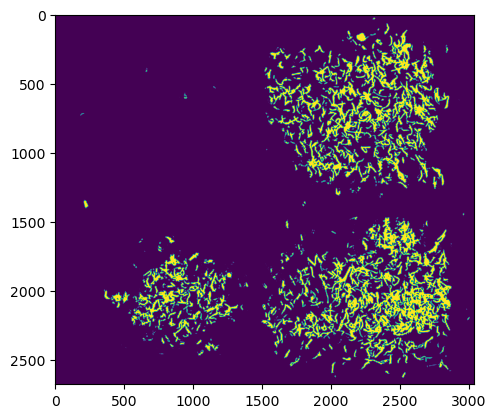

计算连通域耗时： 0.010506153106689453
长度： 249
周长耗时： 0.0010826587677001953
修正离群中心点耗时： 0.005543947219848633
计算np.where耗时： 0.0019419193267822266
计算网格耗时： 0.0036020278930664062
后处理耗时： 0.022225379943847656


In [147]:
if __name__ == '__main__':
    root = r'gray.png'
    img = cv.imread(root,flags=0)

    plt.imshow(img)
    plt.show()
    
    t1 = time()
    a, b = calculate_center(img, reduce_factor = 2)
    print('后处理耗时：', time()-t1)
#     plt.imshow(b)
#     plt.show()

In [5]:
a = np.random.randint(10, size=(10, 10))

In [8]:
a

array([[6, 8, 1, 4, 8, 6, 7, 9, 4, 6],
       [7, 7, 3, 3, 6, 0, 7, 4, 3, 0],
       [8, 9, 9, 5, 5, 5, 9, 7, 9, 8],
       [1, 0, 5, 4, 3, 5, 0, 0, 2, 8],
       [5, 0, 1, 0, 3, 6, 6, 7, 9, 6],
       [6, 6, 3, 8, 9, 3, 2, 0, 1, 4],
       [1, 4, 5, 7, 0, 2, 8, 5, 2, 1],
       [6, 1, 7, 5, 7, 3, 0, 1, 9, 9],
       [4, 0, 5, 2, 3, 6, 8, 0, 0, 3],
       [1, 3, 6, 3, 8, 3, 3, 7, 2, 9]])

In [14]:
len(np.where(a[1,:]==7))

3.0

In [10]:
np.where(a[1,:]==7)

(array([0, 1, 6], dtype=int64),)

In [94]:
b

array([[ True, False, False, ..., False,  True, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [31]:
def filter_duplicate_first_elements(input_list):
    unique_first_elements = set()
    filtered_list = []

    for sublist in input_list:
        first_element = sublist[1]

        # 如果第一个元素不在集合中，说明是第一次出现，保留该小列表
        if first_element not in unique_first_elements:
            filtered_list.append(sublist)
            unique_first_elements.add(first_element)

    return filtered_list

# 示例
input_list = [[1, 'apple'], [2, 'apple'], [1, 'banana'], [3, 'grape'], [2, 'kiwi']]
filtered_list = filter_duplicate_first_elements(input_list)

print(filtered_list)


[[1, 'apple'], [1, 'banana'], [3, 'grape'], [2, 'kiwi']]
